In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [3]:
# Disable XLA to avoid potential issues
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'

# Check GPU availability
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))
print("TensorFlow Built with CUDA:", tf.test.is_built_with_cuda())

Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Built with CUDA: True


In [4]:
# Load and preprocess MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1749310861.168526   20190 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
# Define generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(7*7*256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [6]:
# Define discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.2),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [7]:
# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [8]:
# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [9]:
# Initialize models
generator = make_generator_model()
discriminator = make_discriminator_model()

In [10]:
# Define training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    if disc_loss > 0.7:
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [11]:
# Display generated images
def display_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()
    plt.close()

In [12]:
# Training function
def train(dataset, epochs):
    noise_dim = 100
    num_examples_to_generate = 16
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    gen_losses, disc_losses = [], []

    for epoch in range(epochs):
        epoch_gen_loss = 0.0
        epoch_disc_loss = 0.0
        num_batches = 0
        for image_batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{epochs}", total=BUFFER_SIZE//BATCH_SIZE):
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss += float(gen_loss)
            epoch_disc_loss += float(disc_loss)
            num_batches += 1
        avg_gen_loss = epoch_gen_loss / num_batches
        avg_disc_loss = epoch_disc_loss / num_batches
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)
        print(f'Epoch {epoch+1}, Avg Gen Loss: {avg_gen_loss:.4f}, Avg Disc Loss: {avg_disc_loss:.4f}')
        if (epoch + 1) % 10 == 0:
            display_images(generator, epoch + 1, seed)

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), gen_losses, label='Generator Loss')
    plt.plot(range(1, epochs + 1), disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()
    plt.close()

Epoch 1/50:   0%|                                                                               | 0/468 [00:00<?, ?it/s]E0000 00:00:1749310929.459987   20190 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1749310929.725984   20310 cuda_dnn.cc:529] Loaded cuDNN version 90300
Epoch 1/50: 469it [00:24,  5.01it/s]                                                                                    2025-06-07 21:12:32.578297: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 1/50: 469it [00:24, 18.89it/s]


Epoch 1, Avg Gen Loss: 0.7267, Avg Disc Loss: 1.2675


Epoch 2/50: 100%|█████████████████████████████████████████████████████████████████████| 468/468 [00:16<00:00, 25.60it/s]2025-06-07 21:12:48.922697: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 2/50: 469it [00:16, 28.71it/s]                                                                                    


Epoch 2, Avg Gen Loss: 0.7467, Avg Disc Loss: 1.3647


Epoch 3/50: 469it [00:18, 25.53it/s]                                                                                    


Epoch 3, Avg Gen Loss: 0.8043, Avg Disc Loss: 1.3061


Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████▊| 467/468 [00:16<00:00, 25.95it/s]2025-06-07 21:13:23.490155: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 4/50: 469it [00:16, 28.97it/s]                                                                                    


Epoch 4, Avg Gen Loss: 0.8196, Avg Disc Loss: 1.3150


Epoch 5/50: 469it [00:16, 28.83it/s]                                                                                    


Epoch 5, Avg Gen Loss: 0.8442, Avg Disc Loss: 1.2755


Epoch 6/50: 469it [00:18, 25.74it/s]                                                                                    


Epoch 6, Avg Gen Loss: 0.9064, Avg Disc Loss: 1.2520


Epoch 7/50: 469it [00:16, 29.07it/s]                                                                                    


Epoch 7, Avg Gen Loss: 0.9527, Avg Disc Loss: 1.1956


Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████▊| 467/468 [00:18<00:00, 26.00it/s]2025-06-07 21:14:32.333734: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 8/50: 469it [00:18, 25.75it/s]                                                                                    


Epoch 8, Avg Gen Loss: 0.9924, Avg Disc Loss: 1.1577


Epoch 9/50: 469it [00:16, 28.88it/s]                                                                                    


Epoch 9, Avg Gen Loss: 0.9939, Avg Disc Loss: 1.1722


Epoch 10/50: 469it [00:18, 25.73it/s]                                                                                   


Epoch 10, Avg Gen Loss: 1.1059, Avg Disc Loss: 1.0632


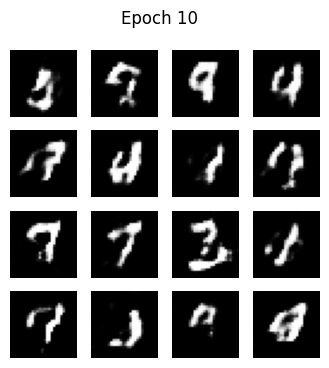

Epoch 11/50: 469it [00:16, 28.91it/s]                                                                                   


Epoch 11, Avg Gen Loss: 1.1441, Avg Disc Loss: 1.0470


Epoch 12/50: 469it [00:18, 25.65it/s]                                                                                   


Epoch 12, Avg Gen Loss: 1.2633, Avg Disc Loss: 1.0096


Epoch 13/50: 469it [00:15, 29.40it/s]                                                                                   


Epoch 13, Avg Gen Loss: 1.2243, Avg Disc Loss: 1.0280


Epoch 14/50: 469it [00:16, 28.62it/s]                                                                                   


Epoch 14, Avg Gen Loss: 1.1674, Avg Disc Loss: 1.1030


Epoch 15/50: 469it [00:18, 25.75it/s]                                                                                   


Epoch 15, Avg Gen Loss: 1.0823, Avg Disc Loss: 1.1656


Epoch 16/50: 100%|████████████████████████████████████████████████████████████████████| 468/468 [00:16<00:00, 26.05it/s]2025-06-07 21:16:48.470604: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 16/50: 469it [00:16, 29.02it/s]                                                                                   


Epoch 16, Avg Gen Loss: 1.0102, Avg Disc Loss: 1.1889


Epoch 17/50: 469it [00:18, 25.54it/s]                                                                                   


Epoch 17, Avg Gen Loss: 0.9780, Avg Disc Loss: 1.2173


Epoch 18/50: 469it [00:16, 28.78it/s]                                                                                   


Epoch 18, Avg Gen Loss: 1.0180, Avg Disc Loss: 1.1990


Epoch 19/50: 469it [00:18, 25.34it/s]                                                                                   


Epoch 19, Avg Gen Loss: 1.0104, Avg Disc Loss: 1.1931


Epoch 20/50: 469it [00:16, 28.53it/s]                                                                                   


Epoch 20, Avg Gen Loss: 0.9621, Avg Disc Loss: 1.2124


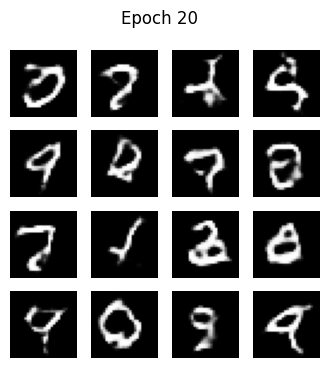

Epoch 21/50: 469it [00:16, 28.58it/s]                                                                                   


Epoch 21, Avg Gen Loss: 0.9639, Avg Disc Loss: 1.2192


Epoch 22/50: 469it [00:18, 25.60it/s]                                                                                   


Epoch 22, Avg Gen Loss: 0.9740, Avg Disc Loss: 1.2204


Epoch 23/50: 469it [00:16, 28.74it/s]                                                                                   


Epoch 23, Avg Gen Loss: 0.9438, Avg Disc Loss: 1.2271


Epoch 24/50: 469it [00:18, 25.67it/s]                                                                                   


Epoch 24, Avg Gen Loss: 0.9681, Avg Disc Loss: 1.2167


Epoch 25/50: 469it [00:16, 29.05it/s]                                                                                   


Epoch 25, Avg Gen Loss: 0.9623, Avg Disc Loss: 1.2163


Epoch 26/50: 469it [00:18, 25.49it/s]                                                                                   


Epoch 26, Avg Gen Loss: 0.9175, Avg Disc Loss: 1.2345


Epoch 27/50: 469it [00:16, 28.89it/s]                                                                                   


Epoch 27, Avg Gen Loss: 0.9836, Avg Disc Loss: 1.2215


Epoch 28/50: 469it [00:18, 25.42it/s]                                                                                   


Epoch 28, Avg Gen Loss: 0.9583, Avg Disc Loss: 1.2207


Epoch 29/50: 469it [00:16, 29.09it/s]                                                                                   


Epoch 29, Avg Gen Loss: 0.9289, Avg Disc Loss: 1.2383


Epoch 30/50: 469it [00:16, 29.22it/s]                                                                                   

Epoch 30, Avg Gen Loss: 0.9241, Avg Disc Loss: 1.2310


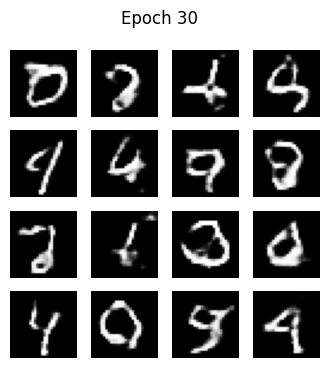

Epoch 31/50: 469it [00:18, 25.63it/s]                                                                                   


Epoch 31, Avg Gen Loss: 0.9643, Avg Disc Loss: 1.2299


Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████▊| 467/468 [00:16<00:00, 25.95it/s]2025-06-07 21:21:23.582329: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Epoch 32/50: 469it [00:16, 29.08it/s]                                                                                   


Epoch 32, Avg Gen Loss: 0.9561, Avg Disc Loss: 1.2158


Epoch 33/50: 469it [00:18, 25.68it/s]                                                                                   


Epoch 33, Avg Gen Loss: 0.9127, Avg Disc Loss: 1.2385


Epoch 34/50: 469it [00:16, 29.08it/s]                                                                                   


Epoch 34, Avg Gen Loss: 0.9481, Avg Disc Loss: 1.2296


Epoch 35/50: 469it [00:18, 25.79it/s]                                                                                   


Epoch 35, Avg Gen Loss: 0.9601, Avg Disc Loss: 1.2213


Epoch 36/50: 469it [00:16, 29.04it/s]                                                                                   


Epoch 36, Avg Gen Loss: 0.9260, Avg Disc Loss: 1.2354


Epoch 37/50: 469it [00:16, 28.98it/s]                                                                                   


Epoch 37, Avg Gen Loss: 0.9165, Avg Disc Loss: 1.2403


Epoch 38/50: 469it [00:18, 25.88it/s]                                                                                   


Epoch 38, Avg Gen Loss: 0.9264, Avg Disc Loss: 1.2441


Epoch 39/50: 469it [00:15, 29.32it/s]                                                                                   


Epoch 39, Avg Gen Loss: 0.9779, Avg Disc Loss: 1.2261


Epoch 40/50: 469it [00:18, 25.85it/s]                                                                                   


Epoch 40, Avg Gen Loss: 0.9280, Avg Disc Loss: 1.2406


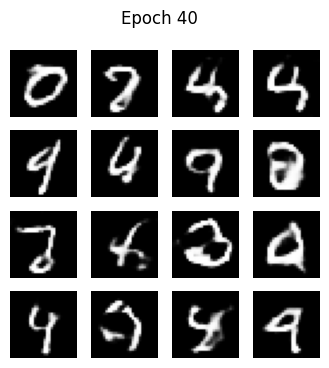

Epoch 41/50: 469it [00:15, 29.36it/s]                                                                                   


Epoch 41, Avg Gen Loss: 0.9262, Avg Disc Loss: 1.2390


Epoch 42/50: 469it [00:18, 25.79it/s]                                                                                   


Epoch 42, Avg Gen Loss: 0.9582, Avg Disc Loss: 1.2305


Epoch 43/50: 469it [00:16, 28.89it/s]                                                                                   


Epoch 43, Avg Gen Loss: 0.9335, Avg Disc Loss: 1.2428


Epoch 44/50: 469it [00:18, 25.88it/s]                                                                                   


Epoch 44, Avg Gen Loss: 0.8943, Avg Disc Loss: 1.2553


Epoch 45/50: 469it [00:16, 29.06it/s]                                                                                   


Epoch 45, Avg Gen Loss: 0.9340, Avg Disc Loss: 1.2472


Epoch 46/50: 469it [00:16, 29.03it/s]                                                                                   


Epoch 46, Avg Gen Loss: 0.9577, Avg Disc Loss: 1.2364


Epoch 47/50: 469it [00:18, 25.84it/s]                                                                                   


Epoch 47, Avg Gen Loss: 0.9348, Avg Disc Loss: 1.2441


Epoch 48/50: 469it [00:16, 29.20it/s]                                                                                   


Epoch 48, Avg Gen Loss: 0.9146, Avg Disc Loss: 1.2515


Epoch 49/50: 469it [00:18, 25.71it/s]                                                                                   


Epoch 49, Avg Gen Loss: 0.8984, Avg Disc Loss: 1.2528


Epoch 50/50: 469it [00:15, 29.48it/s]                                                                                   


Epoch 50, Avg Gen Loss: 0.8883, Avg Disc Loss: 1.2653


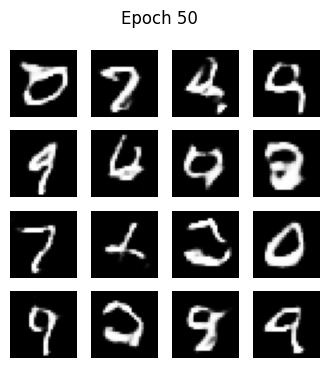

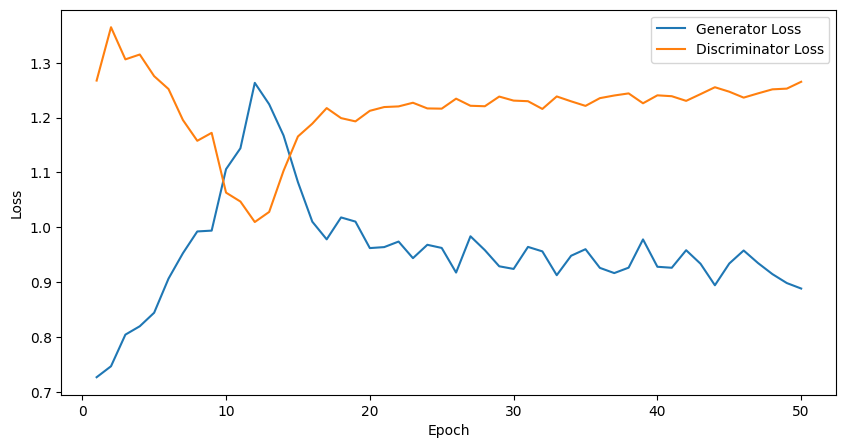

In [13]:
# Run training
EPOCHS = 50
train(train_dataset, EPOCHS)